Análise de caracteristicas das estrelas
---
Este notebook tem como objetivo gerar um modelo que seja capaz de prever a **Classe espectral** de uma estrela baseado em seus atributos. a base utilizada é da YBI Foundation.

O arquivo CSV ["Stars.csv"](https://raw.githubusercontent.com/YBIFoundation/Dataset/main/Stars.csv) contém informações sobre diversas estrelas, incluindo:

*   Temperatura (K): Temperatura superficial da estrela em Kelvin.
*   Luminosidade (L/Lo): Luminosidade relativa da estrela em comparação com a luminosidade solar.
*   Raio (R/Ro): Raio relativo da estrela em comparação com o raio solar.
*   Magnitude absoluta (Mv): Magnitude absoluta da estrela, indicando seu brilho intrínseco.
*   Tipo de estrela: Classificação geral da estrela (por exemplo, anã branca, anã vermelha, supergigante).
*   Categoria de estrela: Subclassificação mais detalhada (por exemplo, anã branca, anã vermelha, supergigante).
*   Cor da estrela: Cor observada da estrela.
*   Classe espectral: Classificação espectral da estrela, que indica sua temperatura e características espectrais.




Esses dados são úteis para estudos astronômicos e análises estatísticas relacionadas às propriedades das estrelas.



In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.model_selection import cross_val_score,cross_validate
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression

In [ ]:
stars_data = pd.read_csv('https://raw.githubusercontent.com/YBIFoundation/Dataset/main/Stars.csv', encoding='ISO-8859-1')
stars_data.head()
stars_data.columns =['Temperature (K)','Luminosity (L/Lo)','Radius (R/Ro)','Absolute magnitude (Mv)','Star type','Star category','Star color','Spectral Class']

Primeiramente vamos analisar a distribuição dos dados

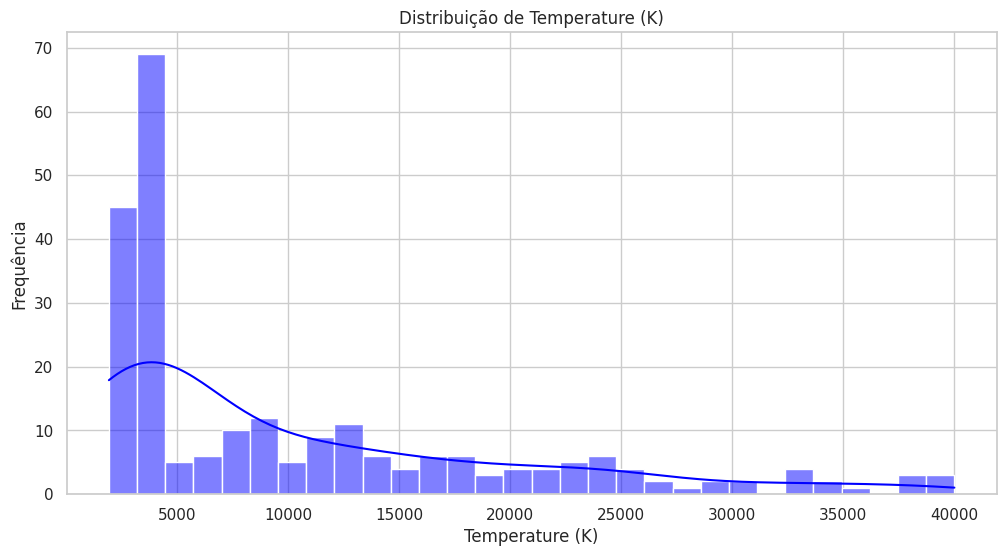

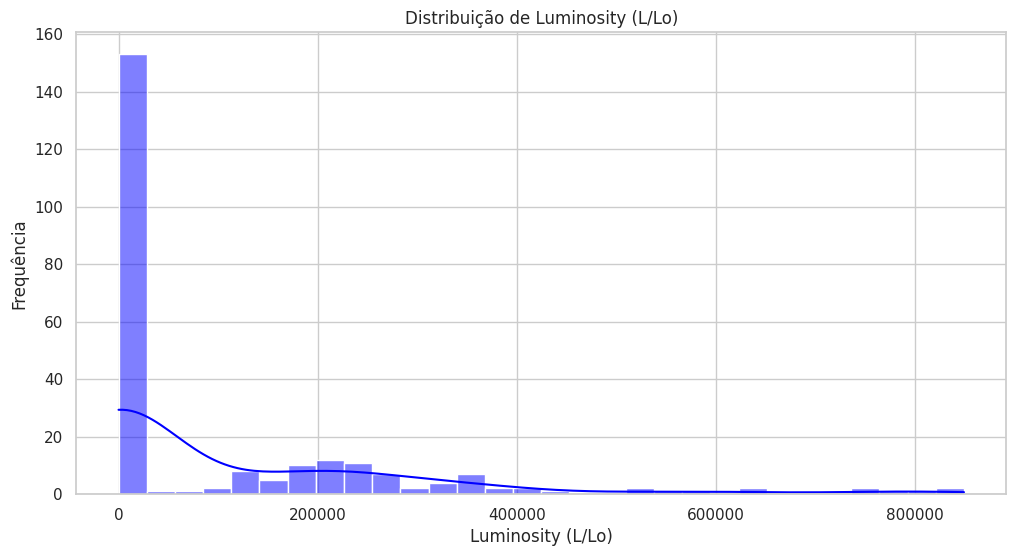

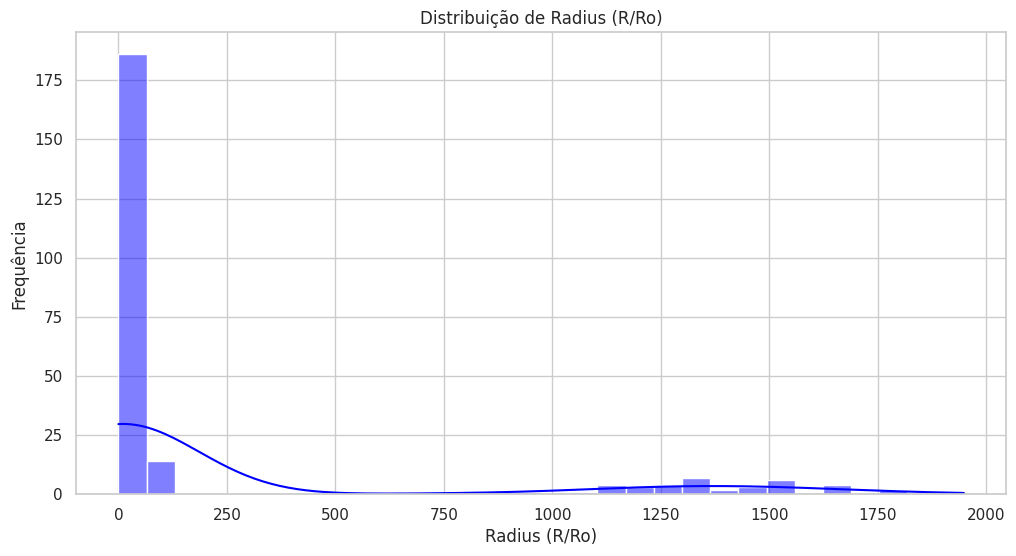

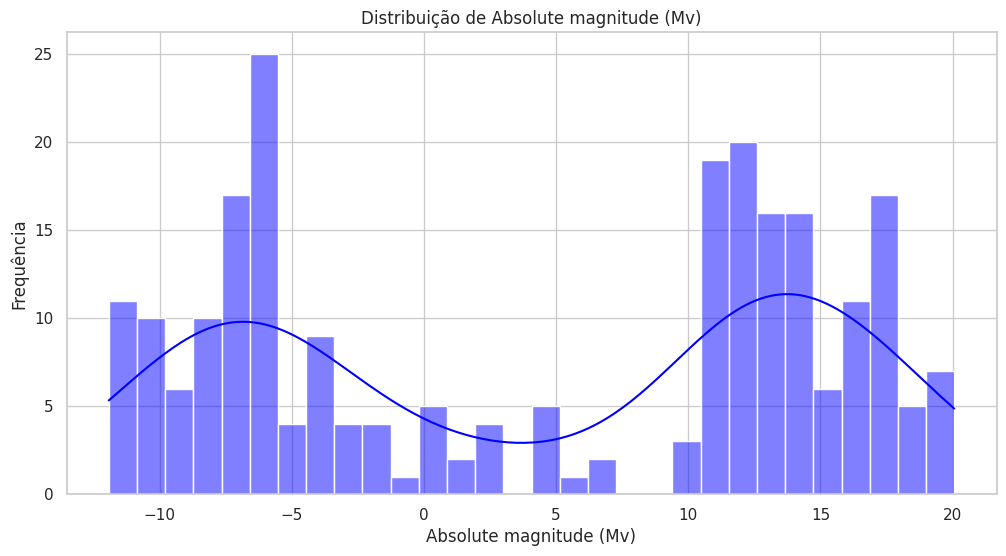

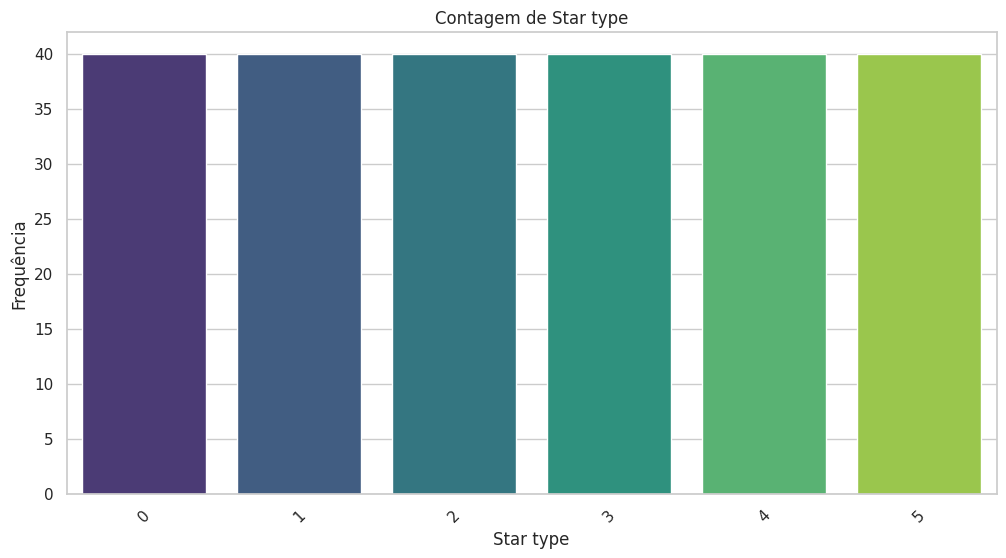

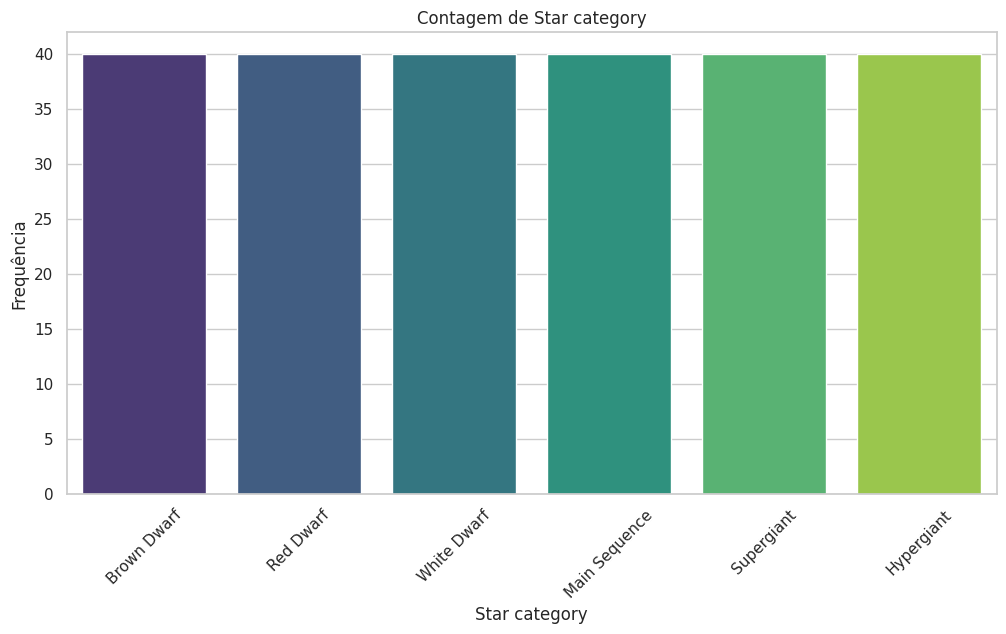

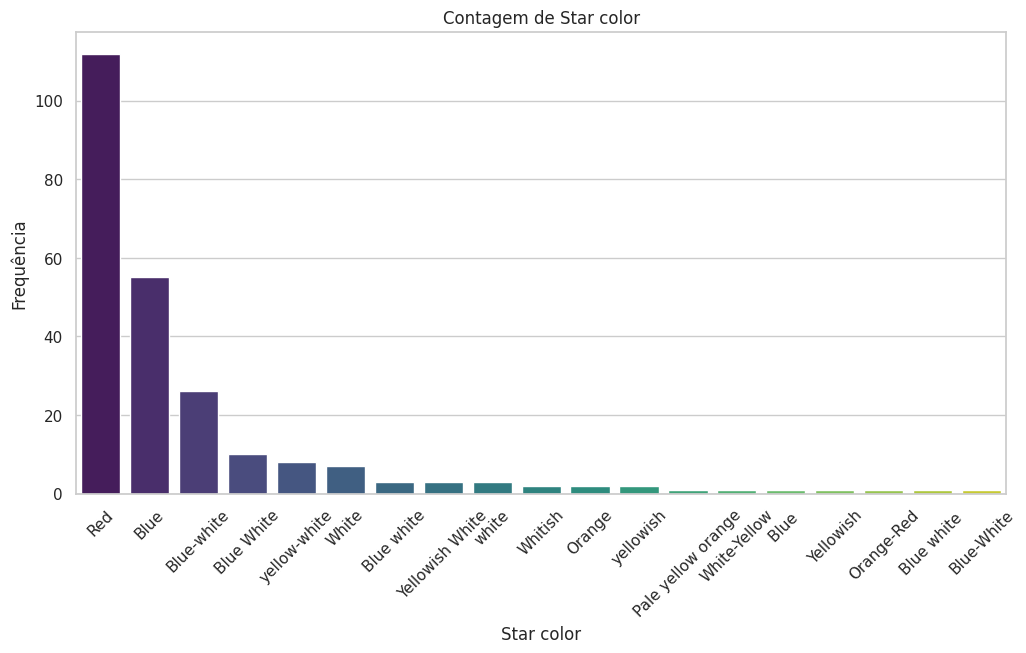

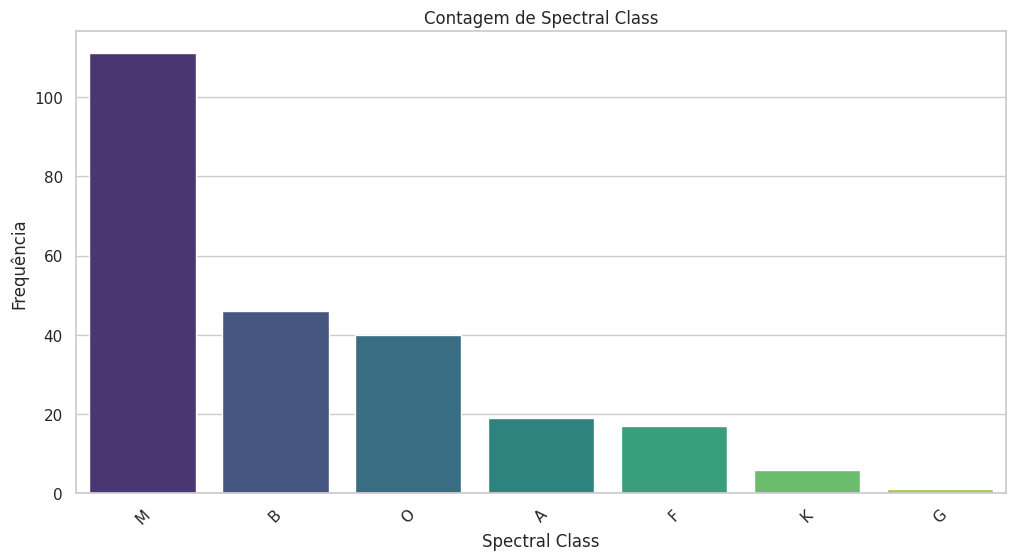

In [ ]:
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)


numerical_columns = ["Temperature (K)", "Luminosity (L/Lo)", "Radius (R/Ro)", "Absolute magnitude (Mv)"]
for column in numerical_columns:
    plt.figure()
    sns.histplot(stars_data[column], kde=True, bins=30, color="blue")
    plt.title(f"Distribuição de {column}")
    plt.xlabel(column)
    plt.ylabel("Frequência")
    plt.show()
#-----------------------------------------------------------------------------------------------------------
categorical_columns = ["Star type", "Star category", "Star color", "Spectral Class"]
for column in categorical_columns:
    plt.figure()
    sns.countplot(data=stars_data, x=column, order=stars_data[column].value_counts().index, palette="viridis")
    plt.title(f"Contagem de {column}")
    plt.ylabel("Frequência")
    plt.xticks(rotation=45)
    plt.show()

Agora podemos fazer o tratamento dos dados para criar um modelo de classificação. Devido ao comportamento inviezado de algumas variáveis, nota-se que as estrelas com Maior luminosidade e maior temperatura se concentram nas cores Vermelha e Azul. Porém, ainda é necessário uma análise de correlação antes de decidir cortar estas variáveis do modelo.

In [ ]:
star_category_encoder = LabelEncoder()
star_color_encoder  = LabelEncoder()
spectral_class_encoder  = LabelEncoder()
stars_data['Star category'] = star_category_encoder.fit_transform(stars_data['Star category'])
stars_data['Star color'] = star_color_encoder.fit_transform(stars_data['Star color'])
stars_data['Spectral Class'] = spectral_class_encoder.fit_transform(stars_data['Spectral Class'])

Em seguida, é necessário medir a correlação entre as variáveis, para isso usamos o método .corr() do dataframe que usa por padrão como medida a correlação de Pearson.

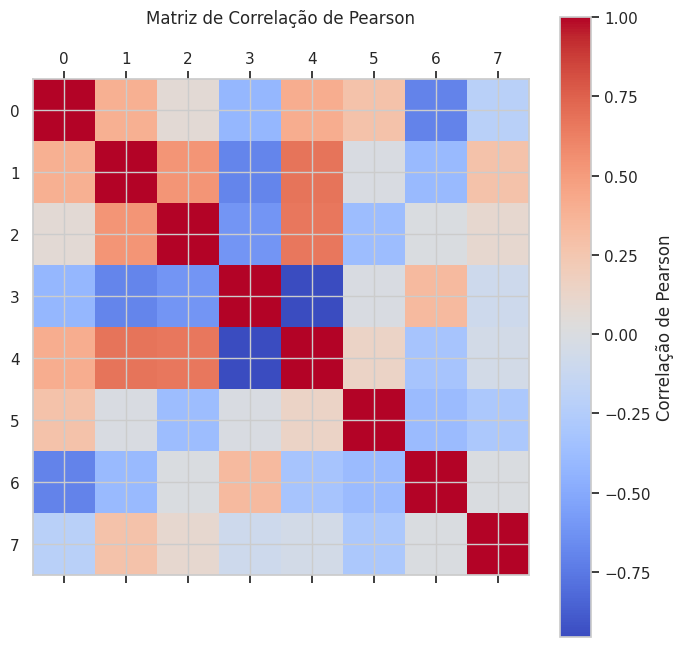

In [ ]:
#plt.matshow(stars_data.corr())
#plt.show()

plt.figure(figsize=(8, 8))
plt.matshow(stars_data.corr(), cmap="coolwarm", fignum=1)
plt.colorbar(label='Correlação de Pearson')
plt.title("Matriz de Correlação de Pearson", pad=20)
plt.show()

As variáveis cujo o cruzamento está representado com cores vibrantes, estão altamente correlacionadas. Com base nisso e na análise de distribuição dos dados foi decidido que as variaveis "Star type", "Luminosity" e "Radius" seriam removidas do dataframe devido ao seu comportamento inviezado e correlacionado a outras variáveis.

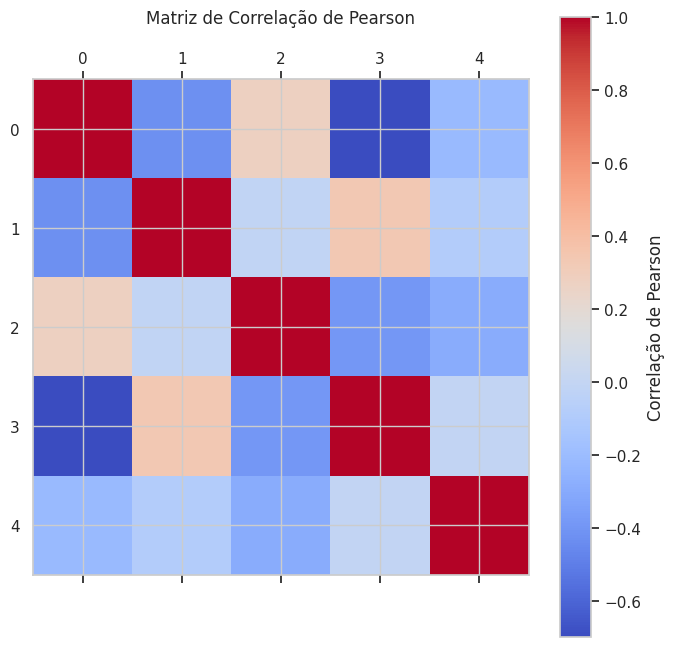

In [ ]:
stars_data = stars_data[['Temperature (K)','Absolute magnitude (Mv)','Star category','Star color','Spectral Class']]
#plt.matshow(stars_data.corr())
#plt.show()

plt.figure(figsize=(8, 8))
plt.matshow(stars_data.corr(), cmap="coolwarm", fignum=1)
plt.colorbar(label='Correlação de Pearson')
plt.title("Matriz de Correlação de Pearson", pad=20)
plt.show()

Aplicando normalização nos dados

In [ ]:
scaler = StandardScaler()

X = scaler.fit_transform(stars_data.values[:,0:4]) # atributos
y = stars_data.values[:,4] # classe (target)

Utilizando o código visto em aula para decidir qual é o melhor algoritmo de classificação para este problema

KNN: 0.880263 (0.047005)
Decision Tree: 0.926842 (0.042381)
Random Forest: 0.937632 (0.045490)
NB: 0.901316 (0.048741)
SVM: 0.870000 (0.052739)
Logistic Regression: 0.859211 (0.053093)


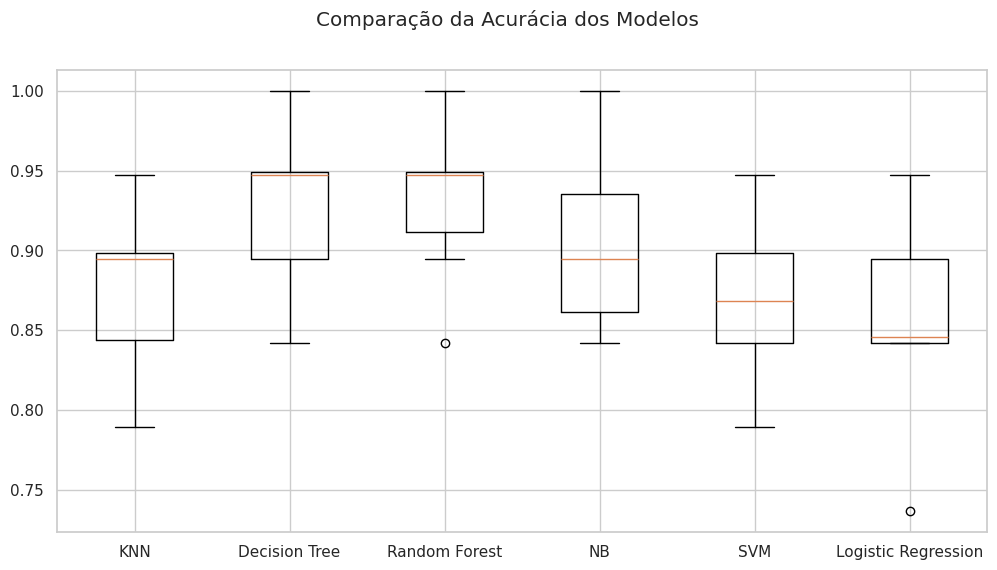

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=7) # faz a divisão

num_particoes = 10
kfold = KFold(n_splits=num_particoes, shuffle=True, random_state=7) # faz o particionamento em 10 folds

# criando o nosso modelo
np.random.seed(7)

models = []
results = []
names = []

models.append(('KNN', KNeighborsClassifier()))
models.append(('Decision Tree', DecisionTreeClassifier()))
models.append(('Random Forest',RandomForestClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('Logistic Regression',LogisticRegression()))

for name, model in models:
  cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

fig = plt.figure()
fig.suptitle('Comparação da Acurácia dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Como o algoritmo que melhor performou com a base de dados foi o ensemble RandomForestClassifier, será feito uma Gridsearch para encontrar a melhor seleção de hiper parâmetros

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Treinar o modelo SVM
model = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=10, n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

Fitting 10 folds for each of 36 candidates, totalling 360 fits


In [ ]:
y_pred_kf = best_model.predict(X_test)
print(f"Acurácia do modelo Random Forest ajustado: {accuracy_score(y_test, y_pred_kf):.4f}")
print("Relatório de Classificação (Random Forest):")
print(classification_report(y_test, y_pred_kf))

Acurácia do modelo Random Forest ajustado: 0.8750
Relatório de Classificação (Random Forest):
              precision    recall  f1-score   support

         0.0       0.67      0.86      0.75         7
         1.0       0.78      1.00      0.88         7
         2.0       0.67      0.40      0.50         5
         5.0       1.00      1.00      1.00        22
         6.0       1.00      0.71      0.83         7

    accuracy                           0.88        48
   macro avg       0.82      0.79      0.79        48
weighted avg       0.88      0.88      0.87        48



Como não obtive melhores resultados alterando os hiperparâmetros, o modelo final foi instânciado usando apenas o class_weight = balanced, pois notei um desequilibrio entre as classes

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=7) # faz a divisão

# criando o nosso modelo
np.random.seed(7)

final_model  = RandomForestClassifier(class_weight='balanced')

final_model.fit(X_train, y_train)
y_pred_final = final_model.predict(X_test)


print(f"Acurácia do modelo Random Forest ajustado: {accuracy_score(y_test, y_pred_final):.4f}")
print("Relatório de Classificação (Random Forest):")
print(classification_report(y_test, y_pred_final))

Acurácia do modelo Random Forest ajustado: 0.9375
Relatório de Classificação (Random Forest):
              precision    recall  f1-score   support

         0.0       0.86      0.86      0.86         7
         1.0       0.88      1.00      0.93         7
         2.0       0.80      0.80      0.80         5
         5.0       1.00      1.00      1.00        22
         6.0       1.00      0.86      0.92         7

    accuracy                           0.94        48
   macro avg       0.91      0.90      0.90        48
weighted avg       0.94      0.94      0.94        48



**Conclusões**

A análise de distribuição dos dados e a correlação de pearson foram elementos chave na melhoria da acurácia do modelo, o melhor caso de acurácia sem a aplicação destas análises girava em torno de 80% de acerto. Após a exclusão das variáveis  "Luminosity (L/Lo)", "Radius (R/Ro)" e "Star Type" houve um aumento considerável na acurácia do modelo, entretanto busquei melhorar ainda mais o modelo utilizando GridSearch mas não obtive melhora aparente nos resultados. Por fim foi decidido que o algoritmo RandomForest sem parâmetrização foi o que melhor performou na base de dados Stars.